In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer 
import re
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn import naive_bayes
import string 
from sklearn.svm import LinearSVC 

In [2]:
train=pd.read_csv('/Users/rouzbehrahimi/Desktop/IE-BD/NLP/First_pro/fake_or_real_news_training.csv')#index_col='ID'

In [3]:
test=pd.read_csv('/Users/rouzbehrahimi/Desktop/IE-BD/NLP/First_pro/fake_or_real_news_test.csv')#index_col='ID'

### We check the two data set shapes and make them unifrom 

In [4]:
test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [6]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [4]:
train[train['X2'].isna()==False ].shape

(2, 6)

In [5]:
train[train['X1'].isna()==False ].shape

(33, 6)

In [7]:
train.shape

(3999, 6)

#### Checking to see if we have duplicated IDs

and as we can see there is no duplicated IDs in neither of train and test sets

In [7]:
train[train.index.duplicated()]

,ID,title,text,label,X1,X2


In [8]:
test[test.index.duplicated()]

,ID,title,text


#### As only 35 rows out of 4000 have values in X1 and X2 columns we decided to drop those columns

In [4]:
train.drop(['X1','X2'],axis=1,inplace=True)

In [7]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


#### As for the feature engineering process we would stack the train and test set, we should make their structure similar therefore we add the label column to the test set 

In [5]:
test['label']=None

In [10]:
test.head()

,ID,title,text,label
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,None
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,None
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,None
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,None
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,None


##### Train and test shape before deleting some rows

In [12]:
test.shape,train.shape

((2321, 4), (3999, 4))

#### As described before we delete the rows with wrong structure

In [6]:
rows_to_delet=train[(train['label']!='FAKE') & (train['label']!='REAL' )].index

In [7]:
train.drop(rows_to_delet,axis=0,inplace=True)

In [8]:
train.reset_index(inplace=True)

In [9]:
train.drop('index',axis=1,inplace=True)

##### Train and test shape after deleting some rows

In [17]:
test.shape,train.shape

((2321, 4), (3966, 4))

#### As this proplem is a classification problem it is quite important to check and see if the dataset is balanced or not
The countplot below shows that the dataset is balanced 

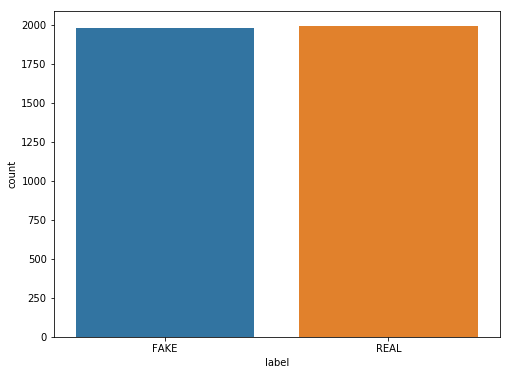

In [18]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot('label',data=train)

### Feature Creation
As we will try differnet methods and variables for finding the best method here we make concat both text and title column in and name them 'mix' which would be used later in the modelling process.

In [10]:
train['mix']=train['title']+train['text']
test['mix']=test['title']+test['text']

In [183]:
train.head()

,ID,title,text,label,mix
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathyU.S...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...


In [184]:
test.head()

,ID,title,text,label,mix
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,None,September New Homes Sales Rise——-Back To 1992 ...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,None,Why The Obamacare Doomsday Cult Can't Admit It...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,None,"Sanders, Cruz resist pressure after NY losses,..."
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,None,Surviving escaped prisoner likely fatigued and...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,None,Clinton and Sanders neck and neck in Californi...


### Lemmatizing train and test seprately

#### Train_lemmatization
This piece of code lemmatize the mix column using the wordnet dictionary to find the pos_tag of words first and then does the lemmatization. It also remove stopwords and punctuations

In [ ]:
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
train["mix"] = [entry.lower() for entry in train["mix"]]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
train["mix"] = [word_tokenize(entry) for entry in train["mix"]]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map["J"] = wn.ADJ
tag_map["V"] = wn.VERB
tag_map["R"] = wn.ADV
for index, entry in enumerate(train["mix"]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words("english") and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    train.loc[index, "mix_final"] = str(Final_words)

In [189]:
train.set_index('ID',inplace=True)

In [190]:
train.head()

,title,text,label,mix,mix_final
ID,,,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[you, can, smell, hillary, ’, s, feardaniel, g...","['smell', 'hillary', 'feardaniel', 'greenfield..."
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[watch, the, exact, moment, paul, ryan, commit...","['watch', 'exact', 'moment', 'paul', 'ryan', '..."
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[kerry, to, go, to, paris, in, gesture, of, sy...","['kerry', 'go', 'paris', 'gesture', 'secretary..."
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[bernie, supporters, on, twitter, erupt, in, a...","['bernie', 'supporter', 'twitter', 'erupt', 'a..."
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[the, battle, of, new, york, :, why, this, pri...","['battle', 'new', 'york', 'primary', 'mattersi..."


#### Test_lemmatization
This piece of code lemmatize the mix column using the wordnet dictionary to find the pos_tag of words first and then does the lemmatization. It also remove stopwords and punctuations

In [187]:
#Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
test["mix"] = [entry.lower() for entry in test["mix"]]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
test["mix"] = [word_tokenize(entry) for entry in test["mix"]]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map["J"] = wn.ADJ
tag_map["V"] = wn.VERB
tag_map["R"] = wn.ADV
for index, entry in enumerate(test["mix"]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words("english") and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    test.loc[index, "mix_final"] = str(Final_words)

In [191]:
test.set_index('ID',inplace=True)

### Stacking train and test dataset for feature engineering

In [193]:
df=train.append(test)

In [194]:
df.head()

,title,text,label,mix,mix_final
ID,,,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[you, can, smell, hillary, ’, s, feardaniel, g...","['smell', 'hillary', 'feardaniel', 'greenfield..."
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[watch, the, exact, moment, paul, ryan, commit...","['watch', 'exact', 'moment', 'paul', 'ryan', '..."
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[kerry, to, go, to, paris, in, gesture, of, sy...","['kerry', 'go', 'paris', 'gesture', 'secretary..."
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[bernie, supporters, on, twitter, erupt, in, a...","['bernie', 'supporter', 'twitter', 'erupt', 'a..."
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[the, battle, of, new, york, :, why, this, pri...","['battle', 'new', 'york', 'primary', 'mattersi..."


### Writing the result into a new csv file

In [195]:
df.to_csv ('/Users/rouzbehrahimi/desktop/IE-BD/NLP/new_df_2.csv', index = 'ID', header=True)

In [24]:
df=pd.read_csv('/Users/rouzbehrahimi/desktop/IE-BD/NLP/new_df.csv',index_col = 'ID')

In [19]:
df.head()

,label,mix,mix_final,text,title
ID,,,,,
8476,FAKE,"['you', 'can', 'smell', 'hillary', '’', 's', '...","['smell', 'hillary', 'feardaniel', 'greenfield...","Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear
10294,FAKE,"['watch', 'the', 'exact', 'moment', 'paul', 'r...","['watch', 'exact', 'moment', 'paul', 'ryan', '...",Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
3608,REAL,"['kerry', 'to', 'go', 'to', 'paris', 'in', 'ge...","['kerry', 'go', 'paris', 'gesture', 'secretary...",U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy
10142,FAKE,"['bernie', 'supporters', 'on', 'twitter', 'eru...","['bernie', 'supporter', 'twitter', 'erupt', 'a...","— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
875,REAL,"['the', 'battle', 'of', 'new', 'york', ':', 'w...","['battle', 'new', 'york', 'primary', 'mattersi...",It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matters


In [20]:
df.shape

(6320, 5)

### Feature Enginnering

In [38]:
tfidf=TfidfVectorizer(ngram_range = (1,1))

In [39]:
mix_tfidf=tfidf.fit_transform(df['mix_final']).todense()

In [40]:
mix_df=pd.DataFrame(mix_tfidf,columns=tfidf.get_feature_names())


In [28]:
mix_df.shape

(6320, 55477)

In [29]:
mix_df.head()

,aa,aaa,aaahhh,aab,aadhar,aadmi,aae,aah,aaj,aakar,...,عن,لم,ما,محاولات,مطالعاتی,من,مورد,هذا,والمرضى,کدآماییposted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [41]:
X_train=mix_df.iloc[:3966,]
X_test=mix_df.iloc[3966:,]
y_train=train['label']

In [212]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
cross_validation = cross_val_score(lr, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
cross_validation

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.88964475, 0.89409985, 0.8985617 ])

In [63]:
cross_validation.mean()

0.8982401942022931

### Naive Bayes Classifier

In [213]:
NB=naive_bayes.MultinomialNB()
NB.fit(X_train,y_train)
cross_validation = cross_val_score(NB, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)

In [214]:
cross_validation

array([0.78684807, 0.79727685, 0.78576836])

### SVM

#### Svm  with mix

In [207]:
X_train=mix_df.iloc[:3966,]
X_test=mix_df.iloc[3966:,]
y_train=train['label']

In [208]:
X_train.head()

,aa,aaa,aaahhh,aab,aadhar,aadmi,aae,aah,aaj,aakar,...,عن,لم,ما,محاولات,مطالعاتی,من,مورد,هذا,والمرضى,کدآماییposted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
from sklearn.model_selection import cross_val_score

In [210]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#SVM.fit(X_train,y_train)
cross_validation = cross_val_score(SVM, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
# predict the labels on validation dataset
#predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
#print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
cross_validation

array([0.92441421, 0.92133132, 0.91370174])

#### Hyper parameter optimization

In [31]:
from sklearn.model_selection import GridSearchCV

In [215]:
parameters = {
    "C": [0.1,1,10]
    
}
SVM = svm.SVC(kernel='linear', degree=3, gamma='auto')
grid_searcher = GridSearchCV(SVM, parameters, n_jobs=-1, verbose=2,cv=3)
grid_searcher.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 44.5min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 46.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 1, 10]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring=None, verbose=2)

In [217]:
grid_searcher.best_score_

0.9198184568835098

In [218]:
grid_searcher.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### It seems that our initial guess for choosing C=1 was not a bad one 

### Giving more importance to title 

In this step we want to give more importance to title column by including it twic in the mix column and we call the mixed column weighted_mix

In [14]:
train_w=train
test_w=test

In [15]:
train_w['weighted_mix']=train_w['title']+train_w['mix']

In [16]:
test_w['weighted_mix']=test_w['title']+test_w['title']

In [17]:
pd.set_option('display.max_colwidth',50)

In [18]:
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
train_w["weighted_mix"] = [entry.lower() for entry in train_w["weighted_mix"]]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
train_w["weighted_mix"] = [word_tokenize(entry) for entry in train_w["weighted_mix"]]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map["J"] = wn.ADJ
tag_map["V"] = wn.VERB
tag_map["R"] = wn.ADV
for index, entry in enumerate(train_w["weighted_mix"]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words("english") and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    train_w.loc[index, "weighted_mix_final"] = str(Final_words)

In [19]:
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
test_w["weighted_mix"] = [entry.lower() for entry in test_w["weighted_mix"]]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
test_w["weighted_mix"] = [word_tokenize(entry) for entry in test_w["weighted_mix"]]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map["J"] = wn.ADJ
tag_map["V"] = wn.VERB
tag_map["R"] = wn.ADV
for index, entry in enumerate(test_w["weighted_mix"]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words("english") and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    test_w.loc[index, "weighted_mix_final"] = str(Final_words)

In [20]:
test_w.set_index('ID',inplace=True)
train_w.set_index('ID',inplace=True)

In [21]:
test_w.head()

,title,text,label,mix,weighted_mix,weighted_mix_final
ID,,,,,,
10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,None,September New Homes Sales Rise——-Back To 1992 ...,"[september, new, homes, sales, rise——-back, to...","['september', 'new', 'home', 'sale', 'level', ..."
2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,None,Why The Obamacare Doomsday Cult Can't Admit It...,"[why, the, obamacare, doomsday, cult, ca, n't,...","['obamacare', 'doomsday', 'cult', 'ca', 'admit..."
864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,None,"Sanders, Cruz resist pressure after NY losses,...","[sanders, ,, cruz, resist, pressure, after, ny...","['sander', 'cruz', 'resist', 'pressure', 'ny',..."
4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,None,Surviving escaped prisoner likely fatigued and...,"[surviving, escaped, prisoner, likely, fatigue...","['survive', 'escape', 'prisoner', 'likely', 'f..."
662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,None,Clinton and Sanders neck and neck in Californi...,"[clinton, and, sanders, neck, and, neck, in, c...","['clinton', 'sander', 'neck', 'neck', 'califor..."


### Creating the weighted dataset

In [22]:
df_w=train_w.append(test_w)

In [23]:
df_w.shape

(6287, 6)

In [24]:
tfidf=TfidfVectorizer(ngram_range = (1,1))
mix_w_tfidf=tfidf.fit_transform(df_w["weighted_mix_final"]).todense()

In [25]:
mix_df_w=pd.DataFrame(mix_w_tfidf,columns=tfidf.get_feature_names())

In [26]:
mix_df_w.shape

(6287, 48528)

### Logistic regression with weighted dataset

In [29]:
X_train=mix_df_w.iloc[:3966,]
X_test=mix_df_w.iloc[3966:,]
y_train=train['label']

In [38]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
cross_validation = cross_val_score(lr, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
cross_validation

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.88284203, 0.89107413, 0.89326268])

### Naive Bayes classifier

In [39]:
NB=naive_bayes.MultinomialNB()
NB.fit(X_train,y_train)
cross_validation = cross_val_score(NB, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
cross_validation

array([0.78382464, 0.79425113, 0.78879637])

### SVM with weighted dataset
It seems that even after giving more weights to title the result did not change. So the initial assumtion that title would be more important than the text did not hold in this case. 

In [41]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#SVM.fit(X_train,y_train)
cross_validation = cross_val_score(SVM, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
# predict the labels on validation dataset
#predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
#print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
cross_validation

array([0.92139078, 0.92284418, 0.91597275])

In [40]:
SVM=LinearSVC()
SVM.fit(X_train,y_train)
cross_validation = cross_val_score(SVM, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
cross_validation

array([0.92365835, 0.92511346, 0.91597275])

### Using chi_square test for feature selection

Aiming to maximize the SVM performance we would narrow down the numebr fo feature through using chi2 test and SelectKbest fuinction. we will do the below for loop to find the best number of the words which seems to be 14000 according to results. 

In [27]:
from sklearn.feature_selection import SelectKBest, chi2

In [35]:
for i in [10000,12000,13000,14000,15000,16000,17000,18000,19000,20000]:
    X_train=mix_df_w.iloc[:3966,]
    X_test=mix_df_w.iloc[3966:,]
    best_k=i
    selector = SelectKBest(chi2, k=best_k)
    fit=selector.fit(X_train, y_train)
#best_words = selector.get_support().nonzero()

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['word','Score']
    best_words=featureScores.nlargest(best_k,'Score').word.values
    X_train=X_train.loc[:,best_words]
    X_test =X_test.loc[:,best_words]
    SVM=LinearSVC()
    SVM.fit(X_train,y_train)
    cross_validation = cross_val_score(SVM, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)
    
    print(f'with {i} best words cross validation score is {cross_validation.mean()}')
    
    

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 10000 best words cross validation score is 0.9251119094749671


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 12000 best words cross validation score is 0.9230941911172231


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 13000 best words cross validation score is 0.9246076230402722


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 14000 best words cross validation score is 0.9253644344382908


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 15000 best words cross validation score is 0.9246083859551334


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 16000 best words cross validation score is 0.9248601474265046


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 17000 best words cross validation score is 0.9246076227517265


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 18000 best words cross validation score is 0.9256160050366739


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 19000 best words cross validation score is 0.9233469060878977


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


with 20000 best words cross validation score is 0.923599049593791


#### As it can be seen above we are getting the best result from K=18000 

In [47]:
X_train=mix_df_w.iloc[:3966,]
X_test=mix_df_w.iloc[3966:,]
best_k=18000
selector = SelectKBest(chi2, k=best_k)
fit=selector.fit(X_train, y_train)
#best_words = selector.get_support().nonzero()

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['word','Score']
best_words=featureScores.nlargest(best_k,'Score').word.values
X_train=X_train.loc[:,best_words]
X_test =X_test.loc[:,best_words]
SVM_final=LinearSVC()
SVM_final.fit(X_train,y_train)
cross_validation = cross_val_score(SVM, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


In [48]:
y_pred=SVM_final.predict(X_test)

In [40]:
test=pd.read_csv('/Users/rouzbehrahimi/Desktop/IE-BD/NLP/First_pro/fake_or_real_news_test.csv')#index_col='ID'

In [44]:
test.shape

(2321, 3)

In [49]:
len(y_pred)

2321

In [51]:
test['label']=y_pred

In [53]:
submission=test

In [54]:
export_csv = submission.to_csv ('NLP_submission.csv', index = None, header=True)

### We exported the submission file here, but kept experiencing new things that unfortunately did not yield better results.

## Ngrams, chi square and SVM

In [55]:
tfidf=TfidfVectorizer(ngram_range = (1,3))
mix_w_tfidf=tfidf.fit_transform(df_w["weighted_mix_final"]).todense()
mix_df_w=pd.DataFrame(mix_w_tfidf,columns=tfidf.get_feature_names())

In [56]:
mix_df_w.shape

(6287, 2499340)

In [57]:
X_train=mix_df_w.iloc[:3966,]
X_test=mix_df_w.iloc[3966:,]
y_train=train['label']

In [58]:
best_k=18000
selector = SelectKBest(chi2, k=best_k)
fit=selector.fit(X_train, y_train)
#best_words = selector.get_support().nonzero()

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['word','Score']
best_words=featureScores.nlargest(best_k,'Score').word.values



/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


In [ ]:
X_train=X_train.loc[:,best_words]
X_test =X_test.loc[:,best_words]

In [35]:
SVM=LinearSVC()
SVM.fit(X_train,y_train)
cross_validation = cross_val_score(SVM, X_train, y_train, cv=3,scoring='accuracy',n_jobs=-1)

In [36]:
cross_validation

array([0.91232048, 0.91754917, 0.91294474])